In [ ]:
from IPython.display import display
from pathlib import Path
from glob import glob
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import folium
import folium.plugins
from pyproj import Geod
from tqdm import tqdm
import random
from sklearn.preprocessing import StandardScaler
geo = Geod(ellps='WGS84')
center_coords=[55.6785706133019, 12.544427257404426]
pd.options.mode.chained_assignment = None

In [ ]:
vao = pd.read_csv((Path.cwd().parent.parent / 'reports' / 'virtual_area_opt.csv'), header=None)
virtual_area_centers = pd.read_csv(Path.cwd().parent.parent / 'data' / 'processed' / 'areas.csv')
rental = pd.read_csv(Path.cwd().parent.parent / 'data' / 'interim' / 'rental.csv', low_memory=False, parse_dates=['Start_Datetime_Local', 'End_Datetime_Local'])
area_centers = rental.groupby('Start_Zone_Name').mean()[['Start_GPS_Latitude','Start_GPS_Longitude']]
openings = pd.read_csv(Path.cwd().parent.parent / 'data' / 'interim' / 'openings.csv', parse_dates=['Created_Datetime_Local'])
locations = pd.read_csv(Path.cwd().parent.parent / 'data' / 'processed' / 'locations.csv', parse_dates=['Time'])

# Data analysis and area generation

In [ ]:
time_start = max(rental['Start_Datetime_Local'].min(), openings['Created_Datetime_Local'].min())
time_end = min(rental['End_Datetime_Local'].max(), openings['Created_Datetime_Local'].max())
total_time = time_end-time_start

service_ratio = []
for _ in tqdm(range(10000)):
    timepoint = time_start + timedelta(seconds=total_time.total_seconds()*random.uniform(0,1))
    current_trips = rental[(rental['Start_Datetime_Local'] <= timepoint) & (rental['End_Datetime_Local'] > timepoint) & (rental['Servicedrive_YN']==1)] # Cars in use
    service_ratio.append(len(current_trips))

all_ratio = []
for _ in tqdm(range(10000)):
    timepoint = time_start + timedelta(seconds=total_time.total_seconds()*random.uniform(0,1))
    current_trips = rental[(rental['Start_Datetime_Local'] <= timepoint) & (rental['End_Datetime_Local'] > timepoint) & (rental['Servicedrive_YN']==0)] # Cars in use
    all_ratio.append(len(current_trips))

### Density histogram of cars being relocated at any date or time

In [ ]:
bins = np.arange(0, 10, 1) # fixed bin size
plt.figure(figsize=(10,7))
ax=plt.subplot(111)
plt.xlim([0.5, 9.5])
plt.xticks(range(1,10))
ax.hist(service_ratio, bins=bins, density=True, align='right')
plt.xlabel('Cars being relocated')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.ylabel('Density')
plt.show()

### Density histogram of cars in rental at any date or time

In [ ]:
bins = np.arange(0, 400, 5) # fixed bin size
plt.figure(figsize=(10,7))
ax=plt.subplot(111)
plt.xlim([0, 400])
ax.hist(all_ratio, bins=bins, density=True, align='right')
plt.xlabel('Cars in rental')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
plt.ylabel('Density')
plt.show()

### Ratio of rentals to relocations

In [ ]:
np.mean(all_ratio)/np.mean(service_ratio)

### Duration of drives

In [ ]:
rental['Duration'] = (rental['End_Datetime_Local']-rental['Start_Datetime_Local']).dt.total_seconds()/60

In [ ]:
bins = np.arange(0, 600, 30) # fixed bin size
plt.figure(figsize=(10,7))
ax=plt.subplot(111)
ax.hist((rental.loc[rental['Servicedrive_YN']==0, 'Duration']), bins=bins, density=True, label='Rentals', alpha=0.7, align='right')
ax.hist((rental.loc[rental['Servicedrive_YN']==1, 'Duration']), bins=bins, density=True, label='Service drives', alpha=0.7, align='right')
plt.legend()
plt.xlabel('Duration in minutes')
plt.yscale('log')
plt.ylabel('Density')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=3))
plt.show()

### Revenue analysis

In [ ]:
plt.figure(figsize=(10,7))
ax=plt.subplot(111)
rental['After_reloc'] = rental.groupby('Vehicle_Number_Plate')['Servicedrive_YN'].shift().fillna(0)
ax.hist(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0)]['Revenue_Net'], bins=range(0,200,10), density=True, alpha=0.5, label='All revenues', align='right')
ax.hist(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==1)]['Revenue_Net'], bins=range(0,200,10), density=True, alpha=0.5, align='right', label='Revenues after relocation')
ax.hist(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==0)]['Revenue_Net'], bins=range(0,200,10), density=True, alpha=0.5, align='right', label='Revenues without relocation')
plt.legend()
plt.xlabel('Revenue')
plt.ylabel('Density')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
plt.show()
print('Mean total:', '{:2.2f}'.format(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0)]['Revenue_Net'].mean()))
print('Mean after relocation:', '{:2.2f}'.format(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==1)]['Revenue_Net'].mean()))
print('Mean without relocation:', '{:2.2f}'.format(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==0)]['Revenue_Net'].mean()))
print('Increase:', '{:2.2%}'.format(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==1)]['Revenue_Net'].mean()/rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0)]['Revenue_Net'].mean()-1))

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
    
rental['After_reloc'] = rental.groupby('Vehicle_Number_Plate')['Servicedrive_YN'].shift().fillna(0)
rev = [rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']!=0)]['Revenue_Net'].mean()]
for _ in tqdm(range(1000)):
    rental['After_reloc'] = rental.groupby('Vehicle_Number_Plate')['After_reloc'].shift().fillna(0)
    rev.append(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']!=0)]['Revenue_Net'].mean())

In [ ]:
# Not used
plt.figure(figsize=(10,7))
ax=plt.subplot(111)
ax.plot(running_mean(rev, 50))
plt.xlabel('$n^{th}$ trip after relocation')
plt.ylabel('Net revenue generated')
plt.show()

In [ ]:
coef = np.polyfit(rental.loc[rental['Servicedrive_YN']==0, 'Duration'], rental.loc[rental['Servicedrive_YN']==0, 'Revenue_Net'], 1)
poly1d_fn = np.poly1d(coef) 

plt.figure(figsize=(10,7))
ax=plt.subplot(111)
ax.scatter(rental.loc[rental['Servicedrive_YN']==0, 'Duration'], rental.loc[rental['Servicedrive_YN']==0, 'Revenue_Net'], s=1, label='Historical rentals')
ax.plot(range(0, 15000, 100), poly1d_fn(range(0, 15000, 100)), c='orange', label='Linear fit')
plt.xlim([1, 15000])
plt.ylim([1, 5000])
plt.xlabel('Duration of the trip in minutes')
plt.ylabel('Net revenue generated')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.show()
print(coef)
np.corrcoef(rental.loc[rental['Servicedrive_YN']==0, 'Duration'], rental.loc[rental['Servicedrive_YN']==0, 'Revenue_Net'])

In [ ]:
rental.loc[rental['Servicedrive_YN']==1]

In [ ]:
d, h = 0, 16
rdh = rental[(rental['Start_Datetime_Local'].dt.weekday==d)]
rdh['Hour'] = rental['Start_Datetime_Local'].dt.hour
rdh = [rdh.loc[rdh['Hour']==i,['Start_GPS_Latitude', 'Start_GPS_Longitude']].values.tolist() for i in range(24)]
odh = openings[(openings['Created_Datetime_Local'].dt.weekday==d)]
odh['Hour'] = openings['Created_Datetime_Local'].dt.hour
odh = [odh.loc[odh['Hour']==i,['GPS_Latitude', 'GPS_Longitude']].values.tolist() for i in range(24)]

In [ ]:
rental_map = folium.Map(center_coords, zoom_start=12, tiles='Stamen Toner')
folium.plugins.HeatMapWithTime(rdh,
name=None, min_opacity=0.5, radius=8,
gradient=None, overlay=True, control=True, show=True, auto_play=True).add_to(rental_map)
display(rental_map)

In [ ]:
open_map = folium.Map(center_coords, zoom_start=12, tiles='Stamen Toner')
folium.plugins.HeatMapWithTime(odh,
name=None, min_opacity=0.5, radius=8, gradient=None, overlay=True, control=True, show=True, auto_play=True).add_to(open_map)
display(open_map)

In [ ]:
rental_map = folium.Map(center_coords, zoom_start=12, tiles='Stamen Toner')
folium.plugins.HeatMap(rdh[h], name=None, min_opacity=0.5, max_zoom=18, radius=5,
blur=5, gradient=None, overlay=True, control=True, show=True).add_to(rental_map)
display(rental_map)

In [ ]:
open_map = folium.Map(center_coords, zoom_start=12, tiles='Stamen Toner')
folium.plugins.HeatMap(odh[h], name=None, min_opacity=0.5, max_zoom=18, radius=9,
blur=10, gradient=None, overlay=True, control=True, show=True).add_to(open_map)

display(open_map)

### App openings vs. rentals

In [ ]:
timepoints = np.arange(time_start, time_end, timedelta(minutes=30))
lens=[np.array([len(rental[(rental['Start_Datetime_Local']>timepoints[i]) & (rental['Start_Datetime_Local']<timepoints[i+1])]),
len(openings[(openings['Created_Datetime_Local']>timepoints[i]) & (openings['Created_Datetime_Local']<timepoints[i+1])])]) for i in tqdm(range(len(timepoints[:-1])))]
lens=np.array(lens)
lens[(lens[:,1]>0)&(lens[:,0]<lens[:,1]),0]/lens[(lens[:,1]>0)&(lens[:,0]<lens[:,1]),1]


In [ ]:
plt.hist(lens[(lens[:,1]>0)&(lens[:,0]<lens[:,1]),0]/lens[(lens[:,1]>0)&(lens[:,0]<lens[:,1]),1], bins=50)
plt.xlim((0,1))
plt.show()

In [ ]:
len(lens[lens[:,1]==0])/len(lens)

In [ ]:
d=lens[(lens[:,1]>0)&(lens[:,0]<lens[:,1]),0]/lens[(lens[:,1]>0)&(lens[:,0]<lens[:,1]),1]
d.mean()

### Area generation

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(vao.iloc[1:,0], vao.iloc[1:,1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
ax=plt.subplot(111)
ax.bar(x=range(1,len(virtual_area_centers)+1), height=rental.groupby('Virtual_Start_Zone_Name')['Vehicle_Number_Plate'].count().sort_values(ascending=False).values/len(rental), alpha=0.7, label='Virtual', width=1)
ax.bar(x=range(1,len(area_centers)+1), height=rental.groupby('Start_Zone_Name')['Vehicle_Number_Plate'].count().sort_values(ascending=False).values/len(rental), alpha=0.7, label='Original', width=1)
plt.xscale('log')
ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
plt.yscale('log')
plt.ylim((0.0001,1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
plt.xlabel('Areas sorted from most to least rentals')
plt.ylabel('Percentage of rentals starting in area')
plt.legend()
plt.show()

In [ ]:
start_map = folium.Map(center_coords, zoom_start=12, tiles='Stamen Toner')
for name, row in area_centers.iterrows():
    folium.CircleMarker(
        radius=5,
        location=[row['Start_GPS_Latitude'], row['Start_GPS_Longitude']],
        color="crimson",
        tooltip=name,
        fill=False,
    ).add_to(start_map)
for name, row in virtual_area_centers.iterrows():
    folium.CircleMarker(
        radius=5,
        location=[row['GPS_Latitude'], row['GPS_Longitude']],
        color="blue",
        tooltip=name, 
        fill=True
    ).add_to(start_map)
display(start_map)

# Results

In [ ]:
def remove_redundant_moves(mp):
    mp = mp[mp!=mp.index] # Clean moves to self
    # Clean areas with delta cars = 0: 4->3 + 3->5 = 4->5
    ji = 0
    while ji <= len(mp):
        jump=True
        jj = 0
        while jump:
            try:
                o = mp[ji]
                mp[ji]=mp[mp[ji]]
                mp.drop(o, inplace=True)
                jj += 1
            except KeyError:
                jump = False
        ji += 1
    mp = mp[mp!=mp.index] # Clean moves to self that originated from loops

In [191]:
scores = {}
all_scores = list(filter(lambda k: 'score' in k, glob(str(Path.cwd().parent.parent / 'reports/train/*/'))))
for score in all_scores:
    all_files = glob(str(score + "/*.csv"))
    revenues = {}
    for file in all_files:
        data = pd.read_csv(file, header=None).mean().values[0]
        revenues[file[file.rfind("sim_")+4:file.rfind(".")]] = data
    scores[score[score.rfind("_")+1:]] = revenues
scores = pd.DataFrame(scores).sort_index()
scores = scores.reindex(scores.columns.sort_values(), axis=1)

In [192]:
sme = scores[scores.index.str.contains('me')]
sme.index = sme.index.str.replace('_me','').astype(int)
sme.sort_index(inplace=True)

sdqn = scores[scores.index.str.contains('dqn')]
sdqn.index = sdqn.index.str.replace('_dqn','').astype(int)
sdqn.sort_index(inplace=True)
sdqn = sdqn[1:]

scqn = scores[scores.index.str.contains('cqn')]
scqn.index = scqn.index.str.replace('_cqn','').astype(int)
scqn.sort_index(inplace=True)
scqn = scqn[1:]

sh = scores[scores.index.str.contains('hist')]

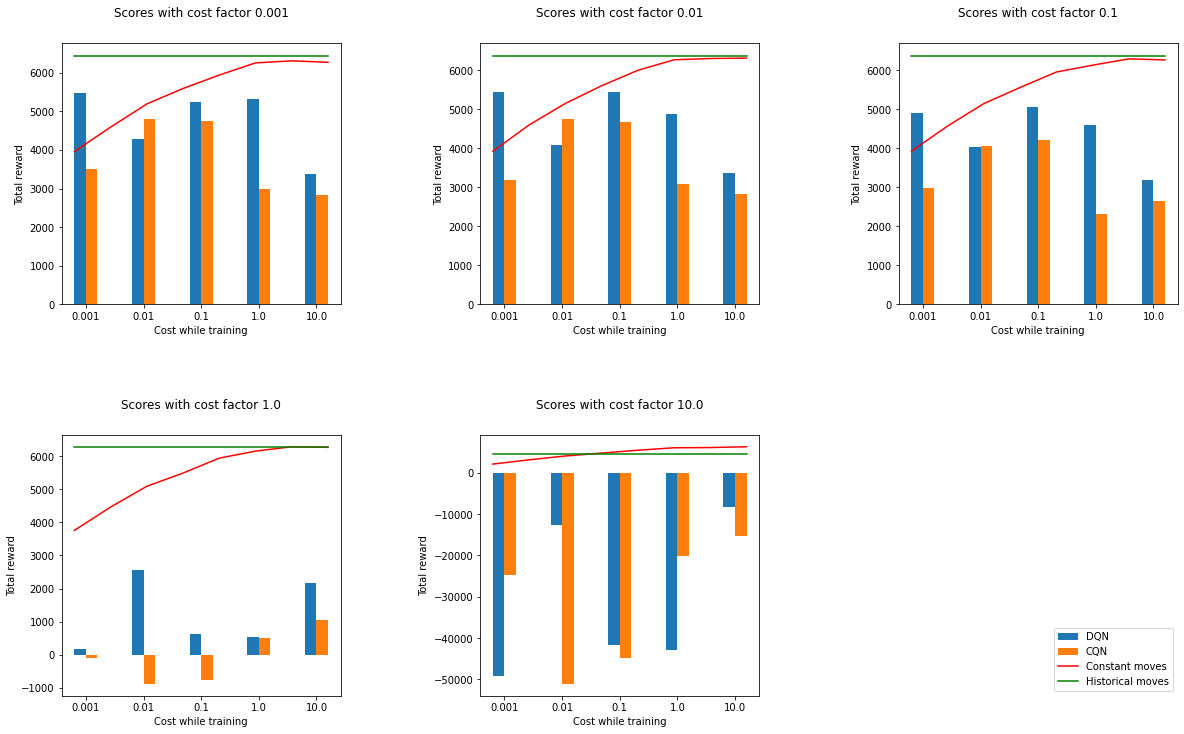

In [197]:
fig = plt.figure(figsize=(20,12))
sp=231
for cost in sh.columns:
    ax1 = plt.subplot(sp)
    ax1.bar(sdqn.index-0.1, sdqn.loc[:,cost], width=0.2, label='DQN')
    ax1.bar(scqn.index+0.1, scqn.loc[:,cost], width=0.2, label='CQN')
    ax2 = ax1.twiny()
    ax2.semilogx(sme.index, sme.loc[:,cost], c='r', label='Constant moves')
    ax2.semilogx(sme.index, [sh.loc[:,cost].values[0]]*len(sme), c='g', label='Historical moves')
    ax2.axis('off')
    ax1.set_title(f'Scores with cost factor {cost}')
    plt.xticks(ticks=range(1,len(sh.columns)+1), labels=sh.columns.values)
    plt.xlabel('Cost while training')
    plt.ylabel('Total reward')
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    sp += 1
ax = plt.subplot(sp) # This and next line to fix lengend position
ax.axis('off')
ax.legend(handles1+handles2, labels1+labels2, loc='lower right')
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [ ]:
time_start, time_window = datetime(2020,6,1,0,0,0), timedelta(minutes=30)
m0 = pd.read_csv((Path.cwd().parent.parent / 'reports' / 'moves_train' / 'td_0_dqn.csv'), header=None)
m1 = pd.read_csv((Path.cwd().parent.parent / 'reports' / 'moves_train' / 'td_1_dqn.csv'), header=None)
m2 = pd.read_csv((Path.cwd().parent.parent / 'reports' / 'moves_train' / 'td_2_dqn.csv'), header=None)
m3 = pd.read_csv((Path.cwd().parent.parent / 'reports' / 'moves_train' / 'td_3_dqn.csv'), header=None)
m4 = pd.read_csv((Path.cwd().parent.parent / 'reports' / 'moves_train' / 'td_4_dqn.csv'), header=None)
m5 = pd.read_csv((Path.cwd().parent.parent / 'reports' / 'moves_train' / 'td_5_dqn.csv'), header=None)
m6 = pd.read_csv((Path.cwd().parent.parent / 'reports' / 'moves_train' / 'td_6_dqn.csv'), header=None)

In [ ]:
pld = timedelta(days=22, hours=8)
i = int(pld.days + pld.seconds/1800)
op = openings[(openings['Created_Datetime_Local']>time_start+pld) & (openings['Created_Datetime_Local']<=time_start+time_window+pld)]
lp = locations[locations['Time']==time_start+pld]
lp=lp.loc[:,lp.columns.str.contains('Vehicle')].sum(axis=1)
mp=m3.iloc[i]
remove_redundant_moves(mp)

In [ ]:
move_map = folium.Map(center_coords, zoom_start=12, tiles='Stamen Toner')
folium.plugins.HeatMap(op.loc[:,['GPS_Latitude', 'GPS_Longitude']], name=None, min_opacity=0.5, max_zoom=18, radius=10,
blur=8, gradient=None, overlay=True, control=True, show=True).add_to(move_map)
for name, row in virtual_area_centers.iterrows():
    folium.CircleMarker(
        radius=5,
        location=[row['GPS_Latitude'], row['GPS_Longitude']],
        color="blue",
        tooltip=name, 
        fill=True
    ).add_to(move_map)
for start, end in mp.iteritems():
    sc = virtual_area_centers.iloc[start, [1,2]].values.tolist()
    ec = virtual_area_centers.iloc[end, [1,2]].values.tolist()
    mpos = [(sc[0]+ec[0])/2, (sc[1]+ec[1])/2]
    _, angle, _ = geo.inv(sc[1], sc[0], ec[1], ec[0])
    folium.RegularPolygonMarker(location=mpos, fill_color='blue', number_of_sides=3, radius=10, rotation=angle+90, opacity=1, fill_opacity=1).add_to(move_map)
    folium.PolyLine(
        locations=[sc,ec],
        weight=2,color = 'blue').add_to(move_map)
display(move_map)

In [ ]:
tm0=(m0!=m0.columns).sum(axis=1)
tm1=(m1!=m1.columns).sum(axis=1)
tm2=(m2!=m2.columns).sum(axis=1)
tm3=(m3!=m3.columns).sum(axis=1)
tm4=(m4!=m4.columns).sum(axis=1)
tm5=(m5!=m5.columns).sum(axis=1)
tm6=(m6!=m6.columns).sum(axis=1)

In [ ]:
plt.hist([tm0, tm1, tm2, tm3, tm4, tm5, tm6], label=['0', '1', '2', '3', '4', '5', '6'])
plt.xticks(range(15,21))
plt.legend()
plt.show()